# 1. Import Libraries

In [4074]:
# Import libraries for data preparation and analysis
import numpy as np
import statistics as stat
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import statistical tests
from statsmodels.tsa.stattools import adfuller, kpss
from numpy import log

# Import normalisation algorithms
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Import feature selection algorithm
from sklearn.decomposition import PCA

# Import algorithm to split dataset
from sklearn.model_selection import train_test_split

# Import algorithms for cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# Import modelling algorithms
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Import evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error as MAPE

# Import hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Import advanced neural networks 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# 2. Define Functions

In [3969]:
# Determine if any missing values in dataset
def find_missing_values(dataset):
    """ This function determines if there are missing data in a dataset and returns a list of the affected attributes
    and number of missing values."""
    _ = dataset.isnull().sum()
    missing_values = _[_ > 0]
    return missing_values

In [3970]:
def model_selection(exclude_model: list, *params):
    """This function adds a wide range of different algorithms primed with specified hyperparameters to a list of models."""
    
    # Create list of models
    models = []
    
    # Add algorithm to list of models
    models.append(("SVR", SVR(**svr_params)))
    models.append(("RFR", RandomForestRegressor(**rfr_params)))
    models.append(("GBR", GradientBoostingRegressor(**gbr_params)))
    models.append(("XGB", XGBRegressor(**xgb_params)))
    return models

In [3971]:
def split_dataset(X, y, test_split: float):
    """This function splits a dataset into training and test sets depending upon specified test split fraction."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=1, shuffle=True)
    return X_train, X_test, y_train, y_test, test_split

In [3972]:
def find_best_worst_model(names: list, MAE_results: list):
    """This function is used to determine the best performing and worst performed trained model \
    on the basis of mean absolute error score."""
    # Create zipped object (names, results)
    model_result = list(zip(names, MAE_results))

    # Find the best performing model 
    best_model = max(model_result, key=lambda x: x[1].mean())

    # Find the worst performing model
    non_best_model = min(model_result, key=lambda x: x[1].mean())

    # Sort model results in descending order
    model_result.sort(key=lambda x: x[1].mean(), reverse=True)

    print(f"Best performing model: {best_model[0]}")
    print(f"Worst performing model: {non_best_model[0]}")
    print("\r")

    print("Five best performing models")
    print("-" * 27)
    for idx, t in enumerate(model_result[:5], start=1):
        print(f"\t{idx}. -> {t[0]}")
    print("\r")

In [3973]:
def plot_cv_scores(MAE_results: list, test_split_fraction: float):
    """This function generates a sequence of boxplots to evaluate trained model performance."""
    # Set plot size
    plt.figure(figsize=(6,4))

    # Plot accuracy scores using boxplots for specified test split
    plt.boxplot(results, labels=names)
    plt.title(f"{test_split_fraction*100}% Test Split: Model Comparision", fontsize=16)
    plt.show()

In [3974]:
def APE(actual_value: float, predicted_value: float):
    """This function is used to calculate the absolute percentage error between an actual value and a predicted value."""
    ape = np.abs((actual_value - predicted_value)/actual_value)*100
    return ape[0]

In [3975]:
def make_prediction_manuf_sales(model, inputs: list, actual_target: int):
    """This function is used to make a prediction about US manufacturers' sales and calculates the percentage error \
    when predicted value is compared against actual target data."""
    predicted_manuf_sales = model.predict([inputs])
    
    # Define actual manufacturers' sales for specific month
    actual_manuf_sales = actual_target
    
    # Compare prediction with actual manufacturers' sales for August 2024
    print(f"Predicted US Manufacturers' Sales: USD ${predicted_manuf_sales[0]:.2f}")
    print(f"Actual US Manufacturers' Sales: USD ${actual_manuf_sales:.2f}" if actual_manuf_sales > 0 else "No data available.")
    print(f"Absolute Percentage Error: {APE(actual_manuf_sales, predicted_manuf_sales):.2f}%" if actual_manuf_sales > 0 else "")

In [3976]:
def extract_data(data, start_date: str, end_date: str):
    """ This function extracts rows from a dataframe for a specified date range (yyyy-dd-mm)."""
    extr = df[(df["Date"].astype(str) >= start_date) & (df["Date"].astype(str) < end_date)]
    return extr

In [3977]:
def compile_data(stored_data, month, pred_value, actual_value):
    """This function is used to collate relevant data (month, prediction, actual sales) about US manufacturers' sales. \
    The data is stored as a dictionary."""
    if "month" in stored_data:
        stored_data["month"].append(month)

    if "pred_value" in stored_data:
        stored_data["pred_value"].append(pred_value)

    if "actual_value" in stored_data and actual_value > 0:
        stored_data["actual_value"].append(actual_value)
    else:
        # If actual value is not known, predicted value is used as a substitute
        stored_data["actual_value"].append(pred_value)

In [3978]:
def model_pred_actual(best_model, stored_data: dict, month: str, inputs: list, actual_manuf_sales: float):
    """ This function uses a tuned model to make a prediction using a list of input variables and then calculates \
    the percentage error of the prediction when compared against the corresponding actual data. """
    # Make prediction
    predicted_manuf_sales = best_model.predict([inputs])

    # Make prediction and calculate percentage error
    make_prediction_manuf_sales(best_model, inputs, actual_manuf_sales)

    # Store data in dictionary
    compile_data(stored_data, month, predicted_manuf_sales[0], actual_manuf_sales)

In [3979]:
def test_stationarity(data_series, data_name: str, log_curve: bool):
    """ This function is used to apply the Augmented Dickey-Fuller Test (ADF) and KPSS Test to ascertain if a time series is \
    stationary or non-stationary. """
    X, title = data_series, data_name

    # Treat data with log function
    if log_curve is True:
        X = log(X)

    # Run statistical tests
    adf_result = adfuller(X, autolag="AIC")
    kpss_result = kpss(X, regression="c")

    print(f"{data_name}")
    print("-" * len(data_name))

    # ADF Test
    print(f"ADF Statistic: {adf_result[0]:.3f}")
    print(f"p-value: {adf_result[1]:.3f}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value}")

    print("\r")
    # Null hypothesis: Plot is unit root (or non-stationary) # Alternative hypothesis (p < 0.05): Plot is stationary
    print("ADF Test Result: Non-stationary time series" if adf_result[1] > 0.05 else "ADF Test Result: Stationary time series")
    print("\r")

    # KPSS Test
    print(f"KPSS Statistic: {kpss_result[0]:.3f}")
    print(f"p-value: {kpss_result[1]:.3f}")
    print(f"Lags used: {kpss_result[2]}")
    print("Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"\t{key}: {value}")

    print("\r")
    # Null hypothesis: Plot is stationary # Alternative hypothesis (p < 0.05): Plot is unit root (non-stationary)
    print("KPSS Test Result: Stationary time series" if kpss_result[1] > 0.05 else "KPSS Test Result: Non-stationary time series")
    print("--" * 25)
    print("\r")

    # Create plot 
    fig, ax = plt.subplots(figsize=(6,4))
    color = "tab:blue"
    plt.title(title, fontsize=16, fontweight="bold")
    plt.xlabel("Date (months)", fontsize=10)
    plt.plot(X, color=color)
    plt.show()
    print("\r\r")

In [3980]:
def detrend_data(data_series, log_curve: bool):
    """ Detrend data series by calculating difference between the nth observation and n-1 observation. """
    if log_curve is True:
        # Calculate logarithm of data_series
        df["_log"] = np.log(df[data_series])
        # Difference nth observation and n-1 observation
        df["diff"] = df["_log"] - df["_log"].shift(1)
    else:
        df["diff"] = df[data_series] - df[data_series].shift(1)
    # Delete missing values
    g = df["diff"].dropna(axis=0)
    return g

# 3. Import Dataset

In [3982]:
# Import consolidated FRED dataset
df = pd.read_csv("Consolidated FRED Source Dataset.csv")

In [3983]:
# Preview of dataset
df.tail(5)

,Date,US Credit Card Rates (%),Date.1,Crude Oil Prices USA,Date.2,Brent Crude Prices Europe,Date.3,Global LNG Price,Date.4,Flexible Price CPI % Change,Date.5,Gold (USD per 100 kg),Date.6,Iron Ore (USD per metric tonne),Date.7,Copper (USD per metric tonne),Date.8,"Actual Manufacturer's Sales (USD, millions)",Date.9,Future M-Sales
684,01/02/2024,21.59,01/02/2024,77.25,01/02/2024,83.48,01/02/2024,8.82225,01/02/2024,1.439474,01/02/2024,710.1,01/02/2024,125.928571,01/02/2024,8304.950476,01/02/2024,556503.0,01/03/2024,606486.0
685,01/03/2024,NaN,01/03/2024,81.28,01/03/2024,85.41,01/03/2024,8.99325,01/03/2024,2.180211,01/03/2024,748.9,01/03/2024,110.190476,01/03/2024,8692.819048,01/03/2024,606486.0,01/04/2024,589418.0
686,01/04/2024,NaN,01/04/2024,85.35,01/04/2024,89.94,01/04/2024,9.79400,01/04/2024,4.469153,01/04/2024,796.9,01/04/2024,112.227273,01/04/2024,9445.593636,01/04/2024,589418.0,01/05/2024,601302.0
687,01/05/2024,21.51,01/05/2024,80.02,01/05/2024,81.75,01/05/2024,10.84700,01/05/2024,-0.625906,01/05/2024,806.9,01/05/2024,119.239130,01/05/2024,10117.163480,01/05/2024,601302.0,01/06/2024,608246.0
688,01/06/2024,NaN,01/06/2024,79.77,01/06/2024,82.25,01/06/2024,12.36800,01/06/2024,-4.572186,01/06/2024,817.5,01/06/2024,108.100000,01/06/2024,9648.167000,01/06/2024,608246.0,01/07/2024,578946.0


# 4. Exploratory Data Analysis 

### View dimensions of dataset

In [3986]:
# Determine number of rows and columns in imported dataset
df.shape

(689, 20)

### View summary of dataset

In [3988]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 20 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Date                                         356 non-null    object 
 1   US Credit Card Rates (%)                     119 non-null    float64
 2   Date.1                                       462 non-null    object 
 3   Crude Oil Prices USA                         462 non-null    float64
 4   Date.2                                       446 non-null    object 
 5   Brent Crude Prices Europe                    446 non-null    float64
 6   Date.3                                       390 non-null    object 
 7   Global LNG Price                             390 non-null    float64
 8   Date.4                                       689 non-null    object 
 9   Flexible Price CPI % Change                  356 non-null    float64
 10  Da

In [3989]:
# Generate list of columns
col_list = df.columns.to_list()

# Generate list of date columns
dates = [col for col in col_list if "Date" in col]

# Convert object data types to date
for date in dates:
    df[date] = pd.to_datetime(df[date]).dt.date

### Truncate dataset to specific date range

In [3991]:
# Exclude data before 1st November 1994
data = df[df.Date.notnull()]

### Remove extraneous dimensions

In [3993]:
# Drop extraneous date columns
for date_col in dates[1:-1]:
    try:
        del data[date_col]
    except Exception as e:
        print(f"{e}: No data")

### Rename selected dimensions

In [3995]:
# Rename "Date.6" and "Actual Manufacturers' Sales" columns
data.rename(columns={"Date.6": "Future Date", "Actual Manufacturer's Sales (USD, millions)": "Manu Sales (USD, millions)"}, inplace=True)

### Checking for missing values

In [3997]:
# Find missing values within dataset
find_missing_values(data)

US Credit Card Rates (%)    237
dtype: int64

In [3998]:
# Fill missing data with previous row values
data.fillna(method="pad", inplace=True)

### Preview of truncated dataset

In [4000]:
# Generate list of dataframe columns
cols_list = data.columns.to_list()

# Generate dataframe excluding last two dimensions, "Future Date" and "Future M-Sales"
df = data.loc[:, data.columns.isin(cols_list[:-2])]
df.head()

,Date,US Credit Card Rates (%),Crude Oil Prices USA,Brent Crude Prices Europe,Global LNG Price,Flexible Price CPI % Change,Gold (USD per 100 kg),Iron Ore (USD per metric tonne),Copper (USD per metric tonne),"Manu Sales (USD, millions)"
333,1994-01-11,15.69,18.07,17.19,3.25,0.244362,138.9,11.45,2803.545411,280455.0
334,1994-01-12,15.69,17.16,15.93,3.23,1.678814,136.8,11.45,2980.699996,279888.0
335,1995-01-01,15.69,18.04,16.55,3.38,2.052855,135.9,12.27,3003.261895,260175.0
336,1995-01-02,16.10,18.57,17.11,3.54,2.093692,136.1,12.27,2870.450158,286290.0
337,1995-01-03,16.10,18.54,17.01,3.80,0.018245,135.9,12.27,2919.673978,303201.0


In [4001]:
# Determine number of rows and columns in truncated dataset
df.shape

(356, 10)

### Normalisation of Dataset For Comparison Purposes

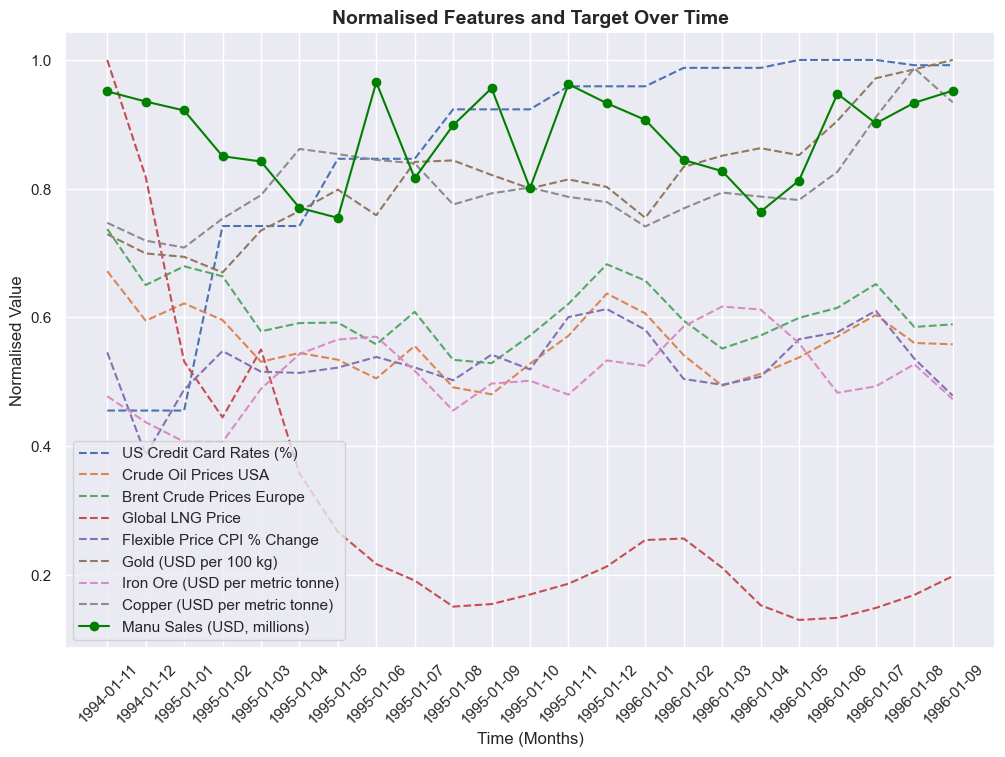

In [4003]:
# Copy data frame
df_duplicate = df.copy()

# Remove date column from dataset
date_column = df_duplicate["Date"]
df_numerical = df_duplicate.drop(columns=["Date"])

# Set up scaler object
scaler = MinMaxScaler()

# Normalise dataset using the scaler object
scaled_data = scaler.fit_transform(df_numerical)

# Create data frame using normalised data and re-attach original "Date" column
scaled_df = pd.DataFrame(scaled_data, columns=df_numerical.columns)
scaled_df["Date"] = date_column

# Filter dataset for dates starting from "1994-01-11"
scaled_df["Date"] = pd.to_datetime(scaled_df["Date"])
scaled_df = scaled_df[scaled_df["Date"] >= "1994-01-11"]

# Convert "Date" column to string format
scaled_df["Date"] = scaled_df["Date"].astype(str)

# Drop any "NAN" values from dataset
scaled_df.dropna(axis=1, inplace=True)

# Define figure to display normalised data
plt.figure(figsize=(12,8))
plt.title("Normalised Features and Target Over Time", fontsize=14, fontweight="bold")
plt.xlabel("Time (Months)")
plt.ylabel("Normalised Value")

for column in df_numerical.columns:
    if column == "Manu Sales (USD, millions)":
        plt.plot(scaled_df["Date"], scaled_df[column], label=column, marker="o", color="green")
    else:
        plt.plot(scaled_df["Date"], scaled_df[column], label=column, ls="--")
    
# Display normalised data with legend for interpretability
plt.legend(loc="best")
plt.xticks(rotation=45)
plt.show();

### Pair plots

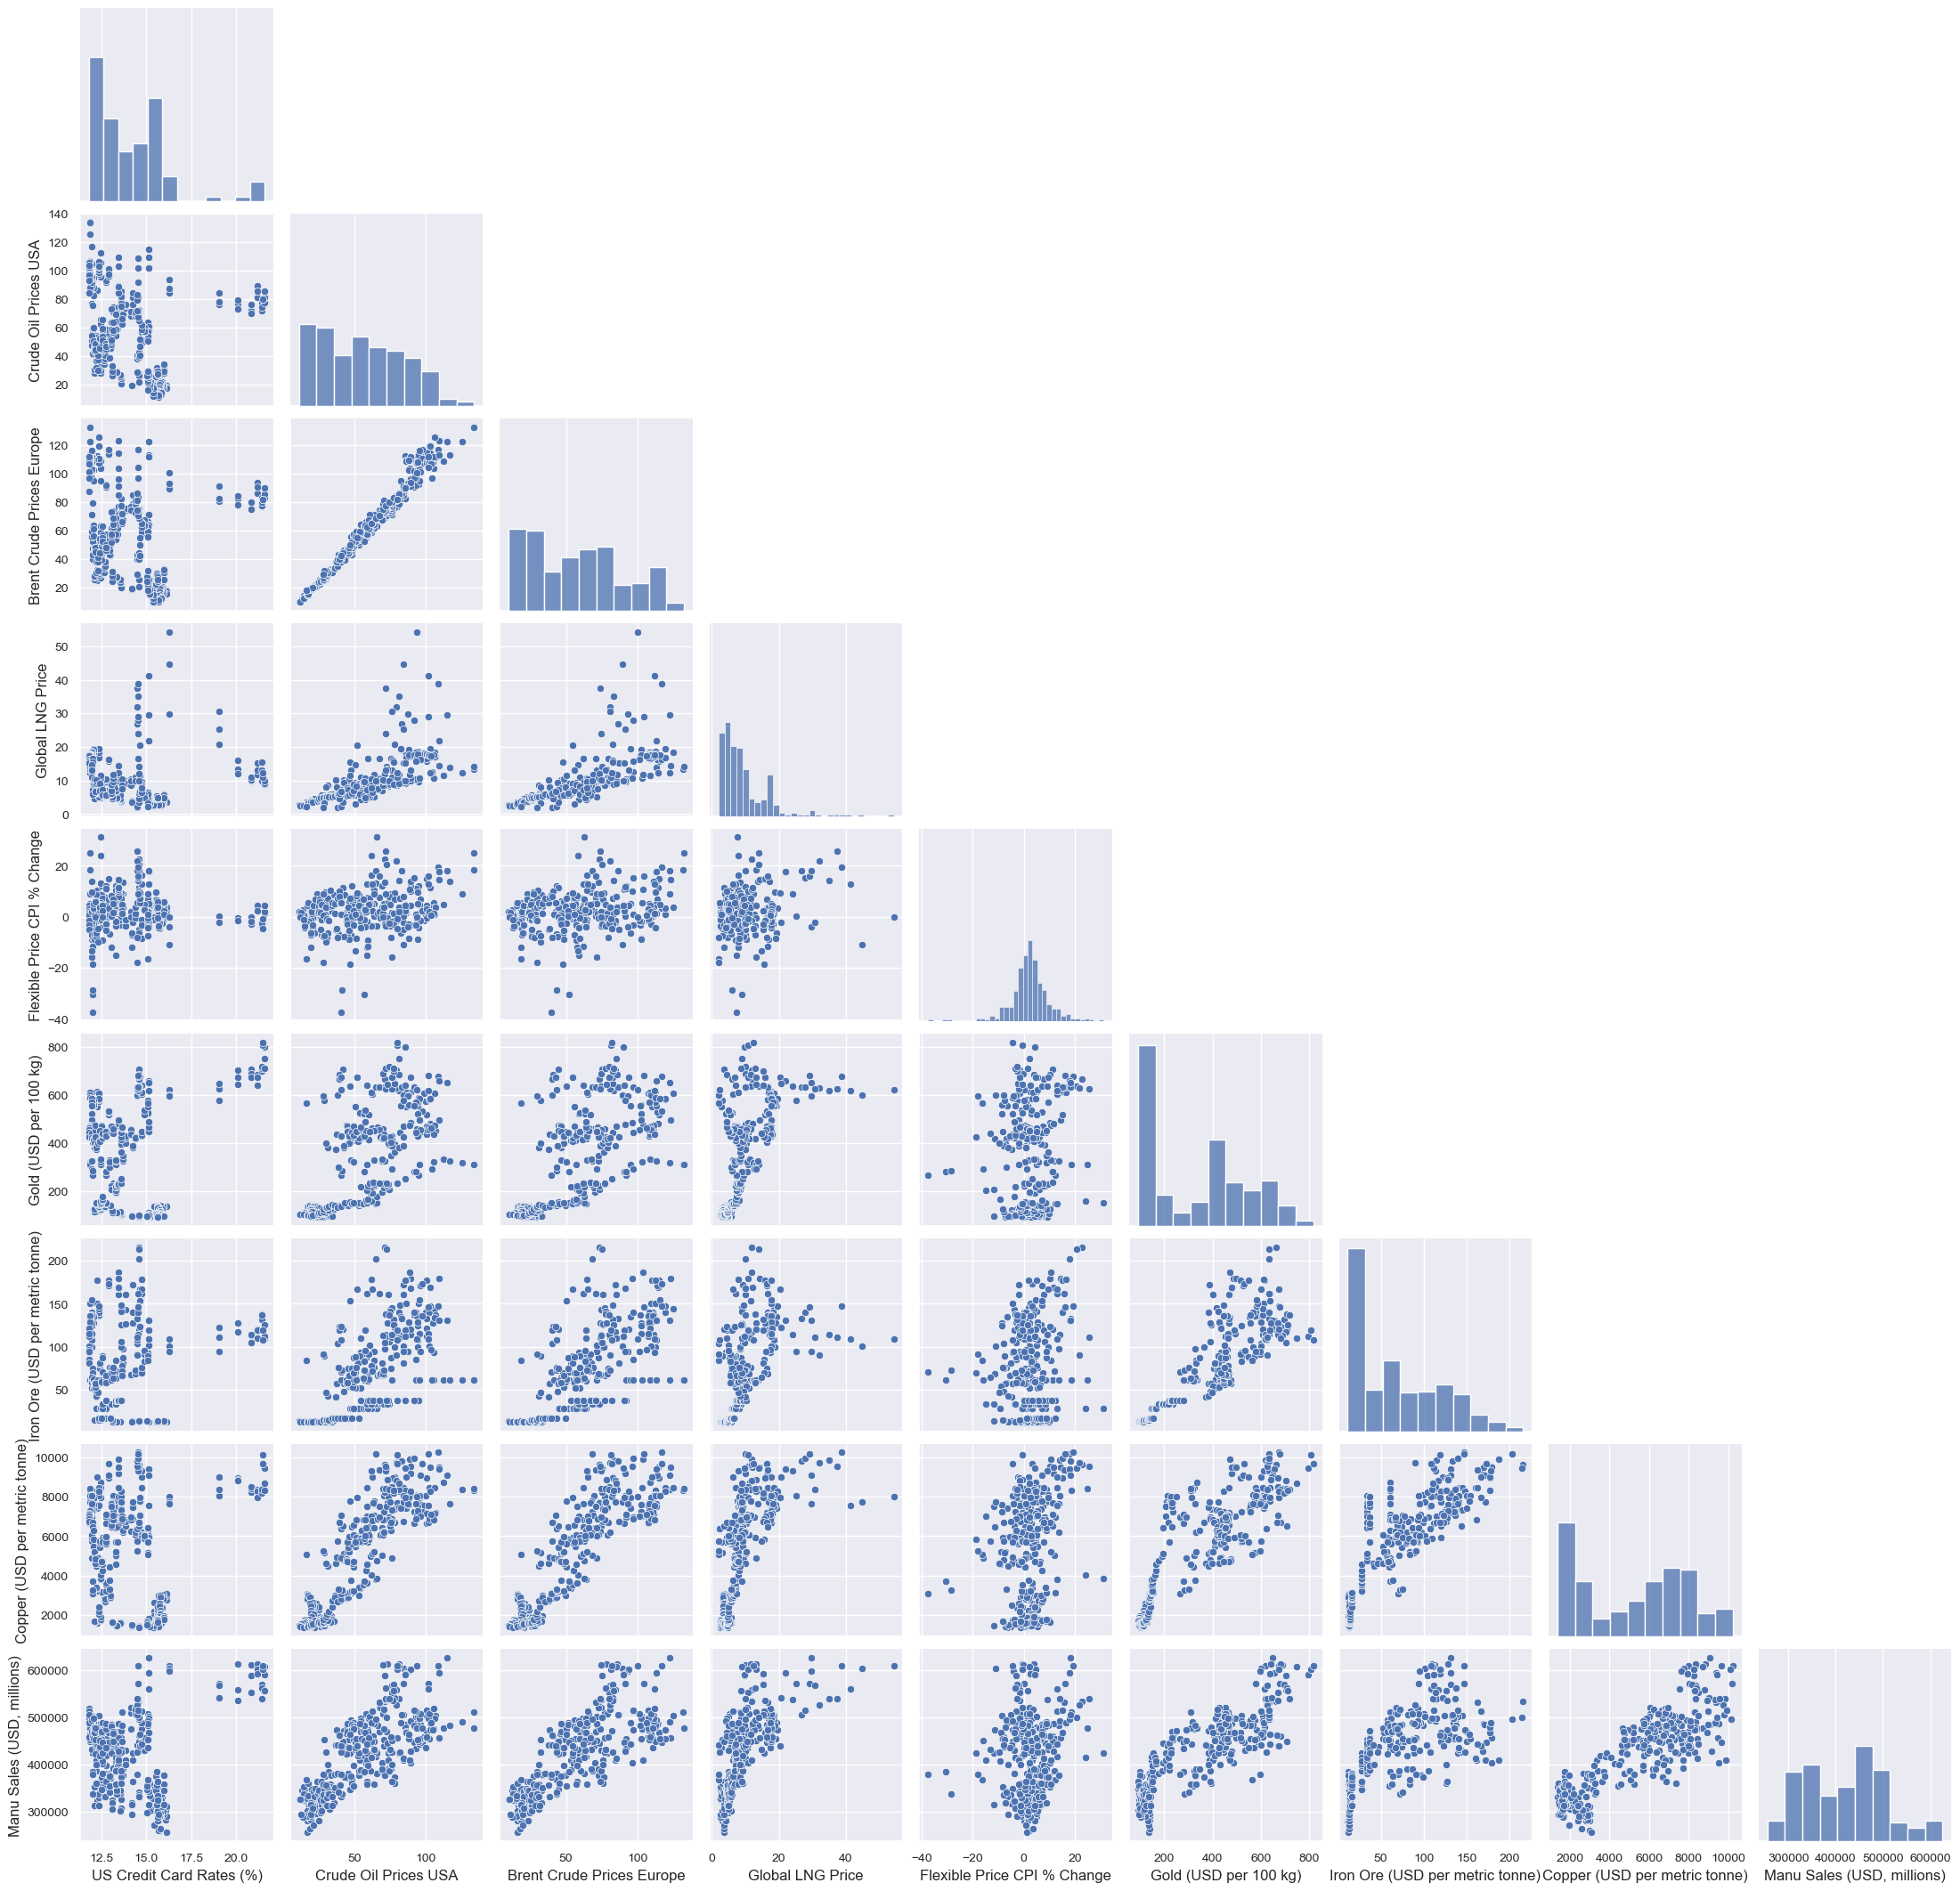

In [4005]:
# Set figure size
sns.set(rc={"figure.figsize":(3,4)})

# Create pair plots
g = sns.pairplot(df, corner=True)

# Adjust label sizes
g.fig.subplots_adjust(top=0.95)

for ax in g.axes.flatten():
    if ax is not None:
        ax.tick_params(labelsize=10)

plt.show()

### Scatter Plots

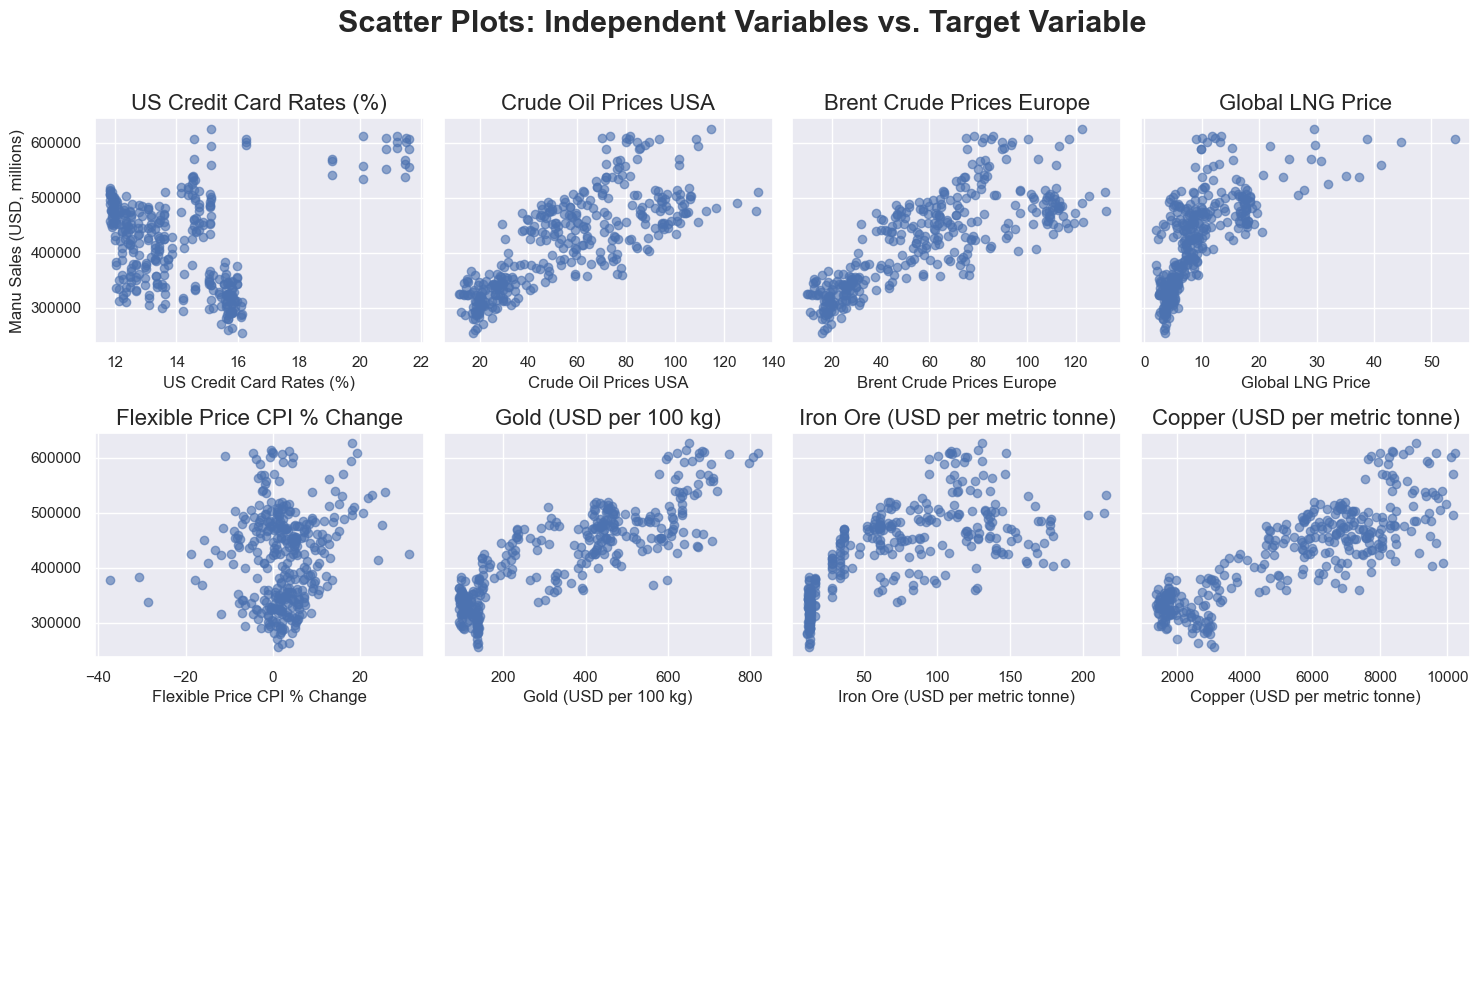

In [4007]:
# Define input variables and target
input_variables = df.columns.to_list()[1:-1]
target_variable = df.columns.to_list()[-1]

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=(len(input_variables) // 2 + len(input_variables) % 2), figsize=(15,10), sharey=True)
fig.suptitle("Scatter Plots: Independent Variables vs. Target Variable", fontsize=22, fontweight="bold")

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Generate scatter plots for each input variable
for i, input_var in enumerate(input_variables):
    axes[i].scatter(df[input_var], df[target_variable], alpha=0.6, color="b")
    axes[i].set_title(input_var, fontsize=16)
    axes[i].set_xlabel(input_var, fontsize=12)
    axes[i].set_ylabel(target_variable if i == 0 else "", fontsize=12)

# Hide any unused subplots
for sp in range(len(input_variables), len(axes)):
    axes[sp].axis("off")

# Adjust layout to fit title
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 6-month moving average plots

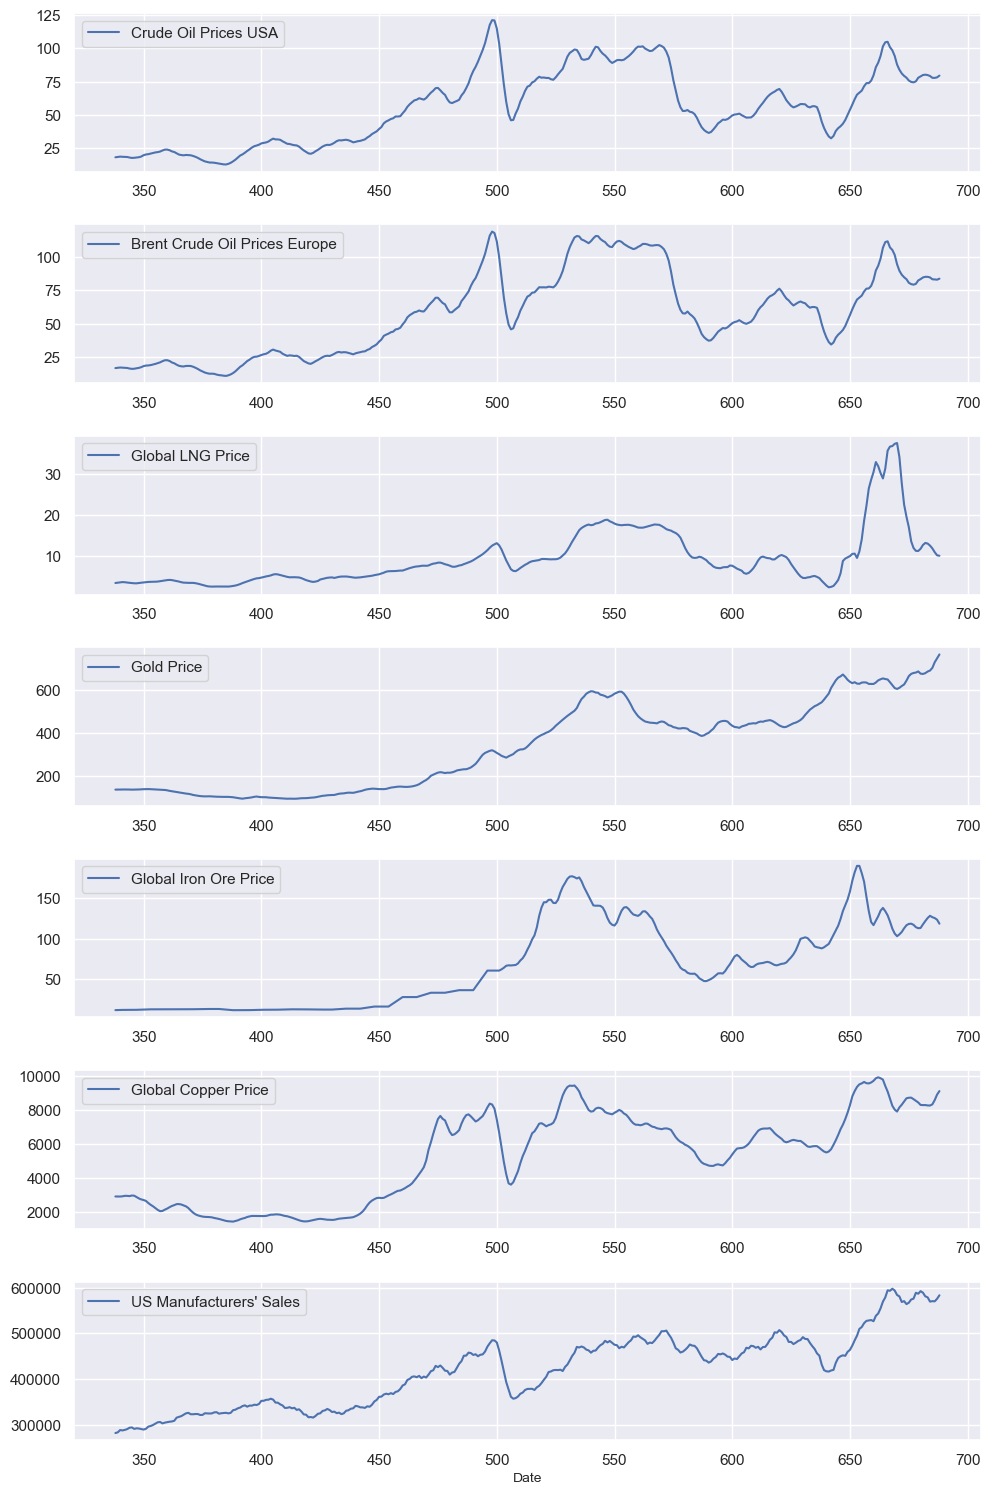

In [4009]:
# Define data for each subplot
_crude_oil_us = df["Crude Oil Prices USA"]
_crude_oil_eur = df["Brent Crude Prices Europe"]
_lng = df["Global LNG Price"]
_manuf_sales = df["Manu Sales (USD, millions)"]
_credit_cards_us = df["US Credit Card Rates (%)"]
_flex_price_change = df["Flexible Price CPI % Change"]
_gold_price = df["Gold (USD per 100 kg)"]
_iron_price = df["Iron Ore (USD per metric tonne)"]
_copper_price = df["Copper (USD per metric tonne)"]

# Calculate 6-month moving average
crude_oil_us_ravg = _crude_oil_us.rolling(window=6).mean()
crude_oil_eur_ravg = _crude_oil_eur.rolling(window=6).mean()
lng_ravg = _lng.rolling(window=6).mean()
gold_ravg = _gold_price.rolling(window=6).mean()
iron_ravg = _iron_price.rolling(window=6).mean()
copper_ravg = _copper_price.rolling(window=6).mean()
manuf_sales_ravg = _manuf_sales.rolling(window=6).mean()

# Create multiple subplots
fig, axes = plt.subplots(7, 1, figsize=(10,15))

# Define padding between subplots
fig.tight_layout(pad=1.2)

# Define subplots axes
y_dict = {
    "1": crude_oil_us_ravg,
    "2": crude_oil_eur_ravg,
    "3": lng_ravg,
    "4": gold_ravg,
    "5": iron_ravg,
    "6": copper_ravg,
    "7": manuf_sales_ravg
}

# Create a zipped object of axes position and label
ax_id = [i for i in range(0,len(y_dict.keys()))]
labels = ["Crude Oil Prices USA", "Brent Crude Oil Prices Europe", "Global LNG Price", \
          "Gold Price", "Global Iron Ore Price", "Global Copper Price", "US Manufacturers' Sales"]

# Show subplots for each label
for n, label in zip(ax_id, labels):
    axes[n].plot(y_dict[str(n+1)], label=label)
    axes[n].legend()

plt.xlabel("Date", fontsize=10)
plt.show()

#### 1. US crude oil prices and manufacturers' sales

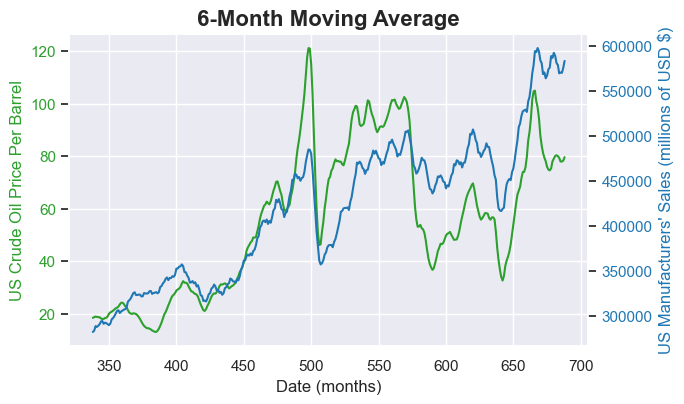

In [4011]:
# Define subplot 
fig, ax1 = plt.subplots(figsize=(6,4))
plt.title("6-Month Moving Average", fontsize=16, fontweight="bold")
fig.tight_layout()

# Subplot 1
color = "tab:green"
ax1.set_xlabel("Date (months)")
ax1.set_ylabel("US Crude Oil Price Per Barrel", color=color)
ax1.plot(_crude_oil_us.rolling(window=6).mean(), color=color)
ax1.tick_params(axis="y", labelcolor=color)

# Create duplicate axes of subplot 1
ax2 = ax1.twinx()

# Subplot 2
color = "tab:blue"
ax2.set_ylabel("US Manufacturers' Sales (millions of USD $)", color=color)
ax2.plot(_manuf_sales.rolling(window=6).mean(), color=color)
ax2.tick_params(axis="y", labelcolor=color)
ax2.grid(False)

plt.show()

#### 2. Brent crude oil prices and US manufacturers' sales

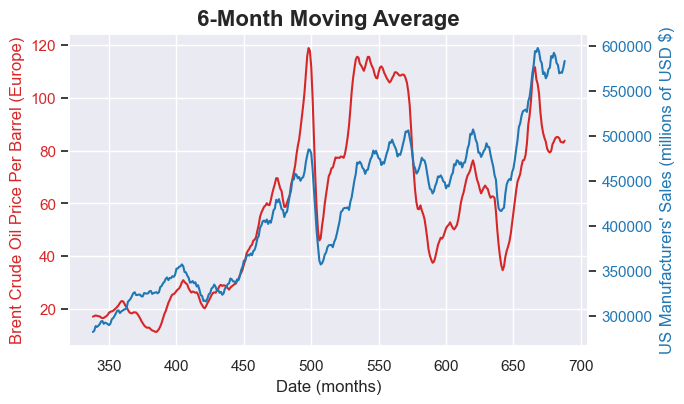

In [4013]:
# Define subplot 
fig, ax1 = plt.subplots(figsize=(6,4))
plt.title("6-Month Moving Average", fontsize=16, fontweight="bold")
fig.tight_layout()

# Subplot 1
color = "tab:red"
ax1.set_xlabel("Date (months)")
ax1.set_ylabel("Brent Crude Oil Price Per Barrel (Europe)", color=color)
ax1.plot(_crude_oil_eur.rolling(window=6).mean(), color=color)
ax1.tick_params(axis="y", labelcolor=color)

# Create duplicate axes of subplot 1
ax2 = ax1.twinx()

# Subplot 2
color = "tab:blue"
ax2.set_ylabel("US Manufacturers' Sales (millions of USD $)", color=color)
ax2.plot(_manuf_sales.rolling(window=6).mean(), color=color)
ax2.tick_params(axis="y", labelcolor=color)
ax2.grid(False)

plt.show()

#### 3. Global LNG prices and US manufacturers' sales

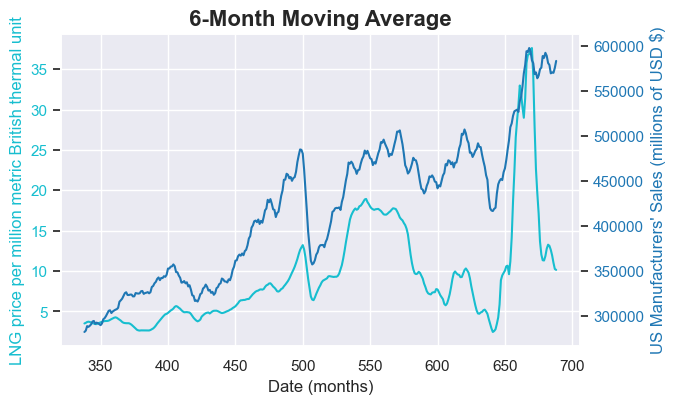

In [4015]:
# Define subplot 
fig, ax1 = plt.subplots(figsize=(6,4))
plt.title("6-Month Moving Average", fontsize=16, fontweight="bold")
fig.tight_layout()

# Subplot 1
color = "tab:cyan"
ax1.set_xlabel("Date (months)")
ax1.set_ylabel("LNG price per million metric British thermal unit", color=color)
ax1.plot(_lng.rolling(window=6).mean(), color=color)
ax1.tick_params(axis="y", labelcolor=color)

# Create duplicate axes of subplot 1
ax2 = ax1.twinx()

# Subplot 2
color = "tab:blue"
ax2.set_ylabel("US Manufacturers' Sales (millions of USD $)", color=color)
ax2.plot(_manuf_sales.rolling(window=6).mean(), color=color)
ax2.tick_params(axis="y", labelcolor=color)
ax2.grid(False)

plt.show()

#### 4. Global Gold Prices and US Manufacturers' Sales

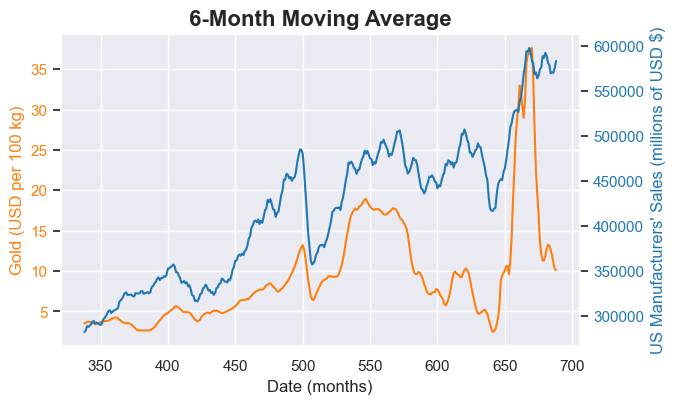

In [4017]:
# Define subplot 
fig, ax1 = plt.subplots(figsize=(6,4))
plt.title("6-Month Moving Average", fontsize=16, fontweight="bold")
fig.tight_layout()

# Subplot 1
color = "tab:orange"
ax1.set_xlabel("Date (months)")
ax1.set_ylabel("Gold (USD per 100 kg)", color=color)
ax1.plot(_lng.rolling(window=6).mean(), color=color)
ax1.tick_params(axis="y", labelcolor=color)

# Create duplicate axes of subplot 1
ax2 = ax1.twinx()

# Subplot 2
color = "tab:blue"
ax2.set_ylabel("US Manufacturers' Sales (millions of USD $)", color=color)
ax2.plot(_manuf_sales.rolling(window=6).mean(), color=color)
ax2.tick_params(axis="y", labelcolor=color)
ax2.grid(False)

plt.show()

#### 5. Gold Iron Ore Prices and US Manufacturers' Sales

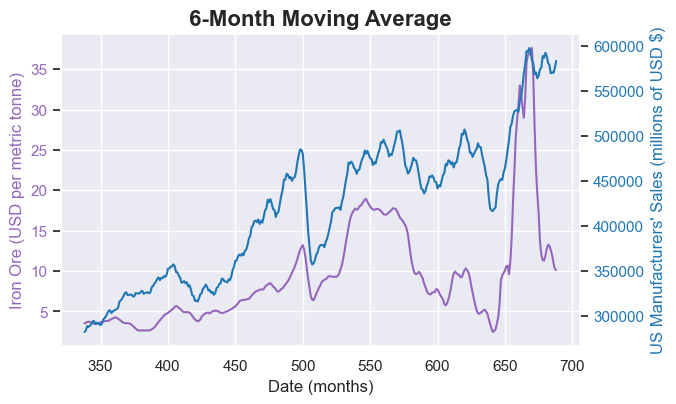

In [4019]:
# Define subplot 
fig, ax1 = plt.subplots(figsize=(6,4))
plt.title("6-Month Moving Average", fontsize=16, fontweight="bold")
fig.tight_layout()

# Subplot 1
color = "tab:purple"
ax1.set_xlabel("Date (months)")
ax1.set_ylabel("Iron Ore (USD per metric tonne)", color=color)
ax1.plot(_lng.rolling(window=6).mean(), color=color)
ax1.tick_params(axis="y", labelcolor=color)

# Create duplicate axes of subplot 1
ax2 = ax1.twinx()

# Subplot 2
color = "tab:blue"
ax2.set_ylabel("US Manufacturers' Sales (millions of USD $)", color=color)
ax2.plot(_manuf_sales.rolling(window=6).mean(), color=color)
ax2.tick_params(axis="y", labelcolor=color)
ax2.grid(False)

plt.show()

#### 6. Global Copper Prices and US Manufacturers' Sales

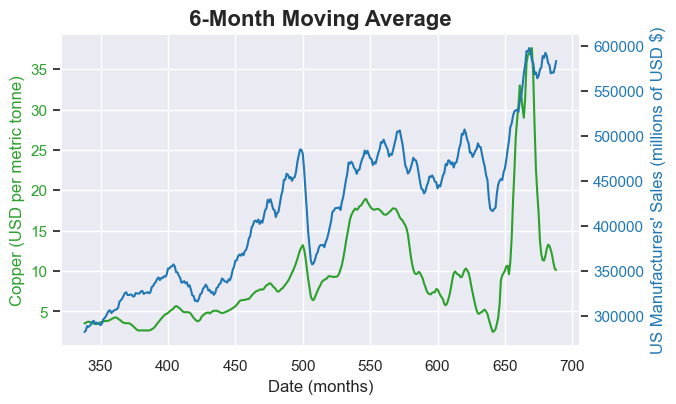

In [4021]:
# Define subplot 
fig, ax1 = plt.subplots(figsize=(6,4))
plt.title("6-Month Moving Average", fontsize=16, fontweight="bold")
fig.tight_layout()

# Subplot 1
color = "tab:green"
ax1.set_xlabel("Date (months)")
ax1.set_ylabel("Copper (USD per metric tonne)", color=color)
ax1.plot(_lng.rolling(window=6).mean(), color=color)
ax1.tick_params(axis="y", labelcolor=color)

# Create duplicate axes of subplot 1
ax2 = ax1.twinx()

# Subplot 2
color = "tab:blue"
ax2.set_ylabel("US Manufacturers' Sales (millions of USD $)", color=color)
ax2.plot(_manuf_sales.rolling(window=6).mean(), color=color)
ax2.tick_params(axis="y", labelcolor=color)
ax2.grid(False)

plt.show()

### Lag Plots

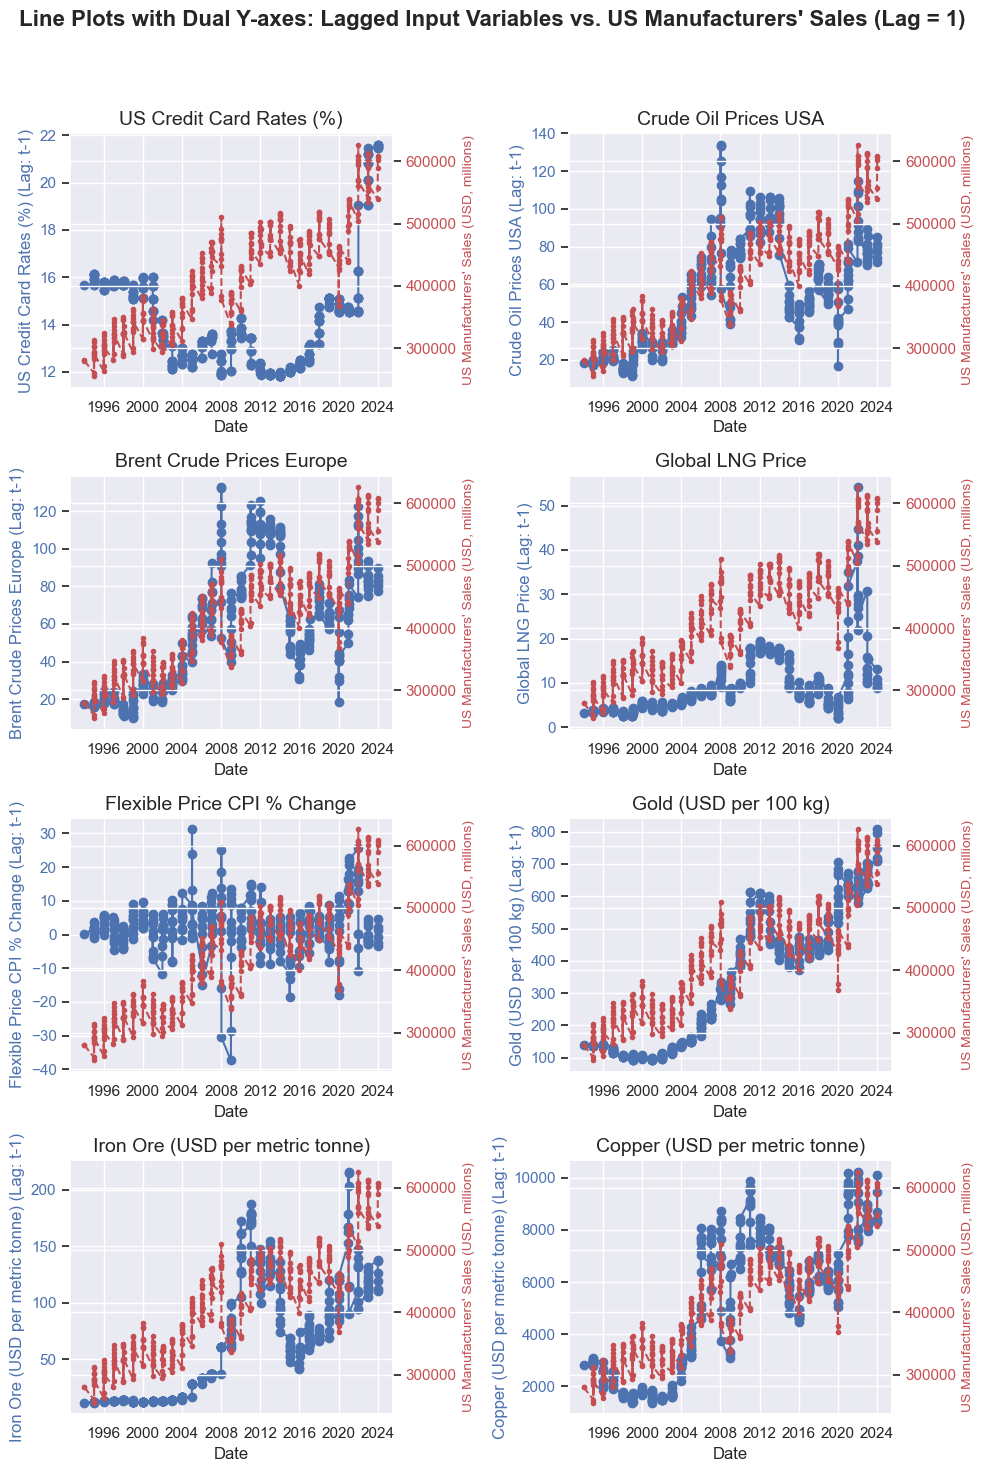

In [4023]:
# Create duplicate of dataset
_df = df.copy()

# Define input variables and target
input_variables = _df.columns.to_list()[1:-1]
target_variable = _df.columns.to_list()[-1]

# Define number of lags (1 lag = 1 month)
n_lags = 1

# Create a series of subplots spread over three rows
#fig, axes = plt.subplots(nrows=3, ncols=(len(input_variables) // 2 + len(input_variables) % 2), figsize=(15,10))
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,15))
fig.suptitle(f"Line Plots with Dual Y-axes: Lagged Input Variables vs. US Manufacturers' Sales (Lag = {n_lags})", fontsize=16, fontweight="bold")

# Flatten axes for easier indexing
axes = axes.flatten()

# Create line plots for each lagged input variable
for i, input_var in enumerate(input_variables):
    # Create lagged version of each input variable
    _df[f"{input_var}_Lag{n_lags}"] = _df[input_var].shift(n_lags)

    # Line plot for lagged input variable on primary y-axis
    ax1 = axes[i]
    ax1.plot(_df["Date"], _df[f"{input_var}_Lag{n_lags}"], label=f"{input_var} (Lag: t-{n_lags})", ls="-", marker="o", color="b")
    ax1.set_xlabel("Date", fontsize=12)
    ax1.set_ylabel(f"{input_var} (Lag: t-{n_lags})", fontsize=12, color="b")
    ax1.tick_params(axis="y", labelcolor="b")

    # Plot target variable on secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(_df["Date"], _df[target_variable], label="US Manufacturers' Sales", ls="--", marker=".", color="r")
    ax2.set_ylabel("US Manufacturers' Sales (USD, millions)", fontsize=10, color="r")
    ax2.tick_params(axis="y", labelcolor="r")

    # Add titles
    ax1.set_title(input_var, fontsize=14)

# Hide unused subplots (if necessary)
for sp in range(len(input_variables), len(axes)):
    axes[sp].axis("off")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# X. Feature Selection

### Correlation Matrix

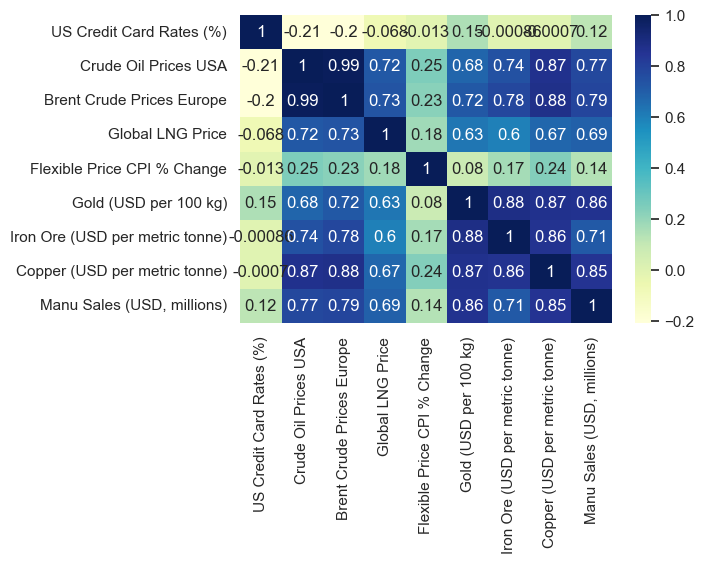

In [4027]:
# Set figure size
fig, ax = plt.subplots(figsize=(6,4))

# Generate heatmap showing correlations between input variables and target variable
matrix = sns.heatmap(df.corr(numeric_only=True), cmap="YlGnBu", annot=True, ax=ax)

# Show heatmap
plt.show()

### Using PCA for Feature Contribution Analysis

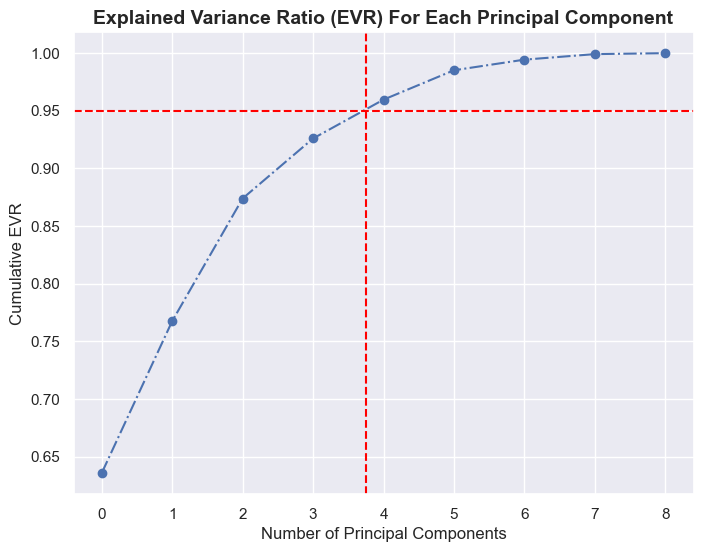


Table of Features Which Contribute to Changes in Target Variable (Principal Components):

                                      PC1       PC2       PC3       PC4  \
US Credit Card Rates (%)        -0.017962  0.845217  0.311398  0.202125   
Crude Oil Prices USA             0.385671 -0.219997 -0.021403  0.091692   
Brent Crude Prices Europe        0.392707 -0.198309 -0.050091  0.055797   
Global LNG Price                 0.332072 -0.071332 -0.025002  0.771675   
Flexible Price CPI % Change      0.102108 -0.259781  0.942235 -0.080077   
Gold (USD per 100 kg)            0.371806  0.281123 -0.088221 -0.277312   
Iron Ore (USD per metric tonne)  0.370318  0.092614 -0.044961 -0.466045   
Copper (USD per metric tonne)    0.399275  0.046138  0.022085 -0.186862   
Manu Sales (USD, millions)       0.375796  0.188605 -0.036601  0.129276   

                                      PC5       PC6       PC7       PC8  \
US Credit Card Rates (%)        -0.254339 -0.286316 -0.023081  0.012956   
Crude Oi

In [4137]:
# Create duplicate of dataset
_df = df.copy()

# Remove "Date" column
df_numerical = _df.drop(columns=["Date"])

# Standardise dataset
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numerical)

# Apply PCA to scaled dataset
pca = PCA()
df_pca = pca.fit_transform(scaled_data)

# Determine Explained Variance Ratio (EVR)
explained_var = pca.explained_variance_ratio_

# Plot EVR to gain understanding of how each principal component influences the target variable, US Manufacturers' Sales
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(explained_var), marker="o", ls="-.")
plt.axhline(y=0.95, color="red", ls="--")
plt.axvline(x=3.75, color="red", ls="--")
plt.title("Explained Variance Ratio (EVR) For Each Principal Component", fontsize=14, fontweight="bold")
plt.xlabel("Number of Principal Components", fontsize=12)
plt.ylabel("Cumulative EVR", fontsize=12)
plt.grid(True)
plt.show()

# Determine contribute of each feature to changes in target variable, US Manufacturers' Sales
pca_components = pd.DataFrame(
    pca.components_,
    columns=df_numerical.columns,
    index=[f"PC{i+1}" for i in range(len(pca.components_))]
)

print()
print("Table of Features Which Contribute to Changes in Target Variable (Principal Components):\n")
print(pca_components.T)
print("----" * 20)
print()

# Identify the features which exert the most influence on Principal Component 1 (PC1)
pc1_features = pca_components.loc["PC1"]
most_important_features = pc1_features.abs().sort_values(ascending=False)

print("Features which exert the most influence on the target variable: US Manufacturers' Sales (USD, millions)")
print()
print(most_important_features)

# X. Stationarity Tests

In [ ]:
# Determine if time series data is stationary or non-stationary
test_stationarity(_credit_cards_us, "US Credit Card Rates (%)", True)
test_stationarity(_flex_price_change, "Flexible Price CPI % Change", False)
test_stationarity(_crude_oil_us, "US Crude Oil Price Per Barrel", True)
test_stationarity(_crude_oil_eur, "Brent Crude Oil Price Per Barrel (Europe)", True)
test_stationarity(_lng, "Global LNG Price Per Million Metric BTU", True)
test_stationarity(_manuf_sales, "US Manufacturers' Sales", True)

### Detrending by differences

In [ ]:
# Detrend and test for stationarity
_credit_cards_us_dt = detrend_data("US Credit Card Rates (%)", False)
test_stationarity(_credit_cards_us_dt, "US Credit Card Rates (%)", False)

_flex_price_change_dt = detrend_data("Flexible Price CPI % Change", False)
test_stationarity(_flex_price_change_dt, "Flexible Price CPI % Change", False)

_crude_oil_us_dt = detrend_data("Crude Oil Prices USA", False)
test_stationarity(_crude_oil_us_dt, "US Crude Oil Price Per Barrel", False)

_crude_oil_eur_dt = detrend_data("Brent Crude Prices Europe", False)
test_stationarity(_crude_oil_eur_dt, "Brent Crude Oil Price Per Barrel (Europe)", False)

_lng_dt = detrend_data("Global LNG Price", False)
test_stationarity(_lng_dt, "Global LNG Price Per Million Metric BTU", False)

_manuf_sales_dt = detrend_data("Manu Sales (USD, millions)", False)
test_stationarity(_manuf_sales_dt, "US Manufacturers' Sales", False)

### Detrended Dataframe

In [ ]:
# Set up dictionary to store detrended data series
data_dict = {
    "Date": df["Date"],
    "US Credit Card Rates (%)": _credit_cards_us_dt,
    "Crude Oil Prices USA": _crude_oil_us_dt,
    "Brent Crude Prices Europe": _crude_oil_eur_dt,
    "Global LNG Price": _lng_dt,
    "Flexible Price CPI % Change": _flex_price_change_dt,
    "Manu Sales (USD, millions)": _manuf_sales_dt
}

# Create dataframe with detrended data
df_dt = pd.DataFrame(data_dict)

In [ ]:
# Check for missing data in detrended dataframe
find_missing_values(df_dt)

In [ ]:
# Drop missing values
df_dt.dropna(axis=0, inplace=True)

In [ ]:
# Preview of detrended dataframe
df_dt.head()

### Detrended correlation matrix

In [ ]:
# Set figure size
fig, ax = plt.subplots(figsize=(6,4))

# Generate heatmap showing correlations between input variables and target variable
matrix = sns.heatmap(df_dt.corr(numeric_only=True), cmap="YlGnBu", annot=True, ax=ax)

# Show heatmap
plt.show()

# 5. Model Development

### Split dataset into input and target variables

In [ ]:
if "diff" in df.columns.to_list():
    df.drop("diff", axis=1, inplace=True)

# Set up training (X) and test (y, "Manu Sales") sets
X = df.drop(["Date", "Manu Sales (USD, millions)"], axis=1)
y = df["Manu Sales (USD, millions)"]

### Create models for sequential testing

### Use models to sequentially train and test dataset

# 6. Hyperparameter tuning using GridSearchCV

### XGBoost Regressor (XGB)

### Support Vector Regressor (SVR)

### Gradient Boosting Regressor (GBR)

### Random Forest Regressor (RFR)

### Create optimised models for sequential training and testing

Hyperparameter tuning has led to the following optimised models:

* XGBRegressor(learning_rate=0.1, max_depth=3, subsample=0.9)
* SVR(C=150, gamma=0.001, kernel="rbf")
* GradientBoostingRegressor(learning_rate=0.08897959183673469, max_depth=3, n_estimators=100)
* RandomForestRegressor(max_depth=12, max_features=None, n_estimators=25)

### Use tuned models to sequentially train on dataset with 10% test split

### Plot cross validation scores for tuned models

# 7. Evaluation of XG Boost Regressor model

Since the best performing model on a 10% test split is XG Boost Regressor, further evaluation of this model will be conducted to ascertain its accuracy and efficacy.

### Fitting XGB to training data

### Evaluate XGB Regressor predictions on 10% test split

When making predictions using the tuned XG Boost Regressor model and comparing these results to the test split, the mean absolute error is 19,098 approximately. In other words, the tuned model's prediction of manufacturing sales is inaccurate by USD $19,098 approximately.

# 8. Make actual predictions using "unseen" data

In [ ]:
# Determine first and last entry in training dataset
df.head(1)

In [ ]:
df.tail(1)

The training dataset contains consolidated data from 1st November 1994 to 1st June 2024. To further evaluate the performance and predictive efficacy of the trained XG Boost Regressor model, it is essential to make a prediction using independent variables from unseen external data after 1st June 2024.

In [ ]:
# Determine list of input variables for model prediction
df.columns.to_list()[1:]

# Set up list to store manufacturers' sales data
stored_data = {
    "month": [],
    "pred_value": [],
    "actual_value": []
}

##### 1. Predict US manufactuers' sales for April 2024

In [ ]:
start_date = "2024-01-04" # yyyy-dd-mm
end_date = "2024-01-05"

extract_data(df, start_date, end_date)

##### 2. Predict US manufactuers' sales for May 2024

In [ ]:
start_date = "2024-01-05" # yyyy-dd-mm
end_date = "2024-01-06"

extract_data(df, start_date, end_date)

##### 3. Predict US manufactuers' sales for June 2024

In [ ]:
start_date = "2024-01-06" # yyyy-dd-mm
end_date = "2024-01-07"

extract_data(df, start_date, end_date)

##### 4. Predict US manufacturers' sales for July 2024

During July 2024, the prices for each of the independent variables and target variable are shown below:

* Commercial Bank Interest Rate on Credit Card Plans, All Accounts (TERMCBCCALLNS): 20.71% (24/07/2024)
* Crude Oil Prices: West Texas Intermediate (WTI) - US dollars per barrel (DCOILWTICO): 84.70 (01/07/2024)
* Crude Oil Prices: Brent - Europe - US dollars per barrel (DCOILBRENTEU): 86.57 (01/07/2024)
* Global price of LNG, Asia - US dollars per million metric British thermal unit (PNGASJPUSDM): 11.995 (01/07/2024)
* Flexible Price Consumer Price Index - % change (FLEXCPIM679SFRBATL): -5.854501247 (01/07/2024)

The target variable, Manufacturers' Sales in the United States, showed the following monetary value during July 2024.

* Manufacturers Sales in Millions of US Dollars (MNFCTRSMNSA): USD $579,032 (01/07/2024)

##### 5. Predict US manufacturers' sales for August 2024

During August 2024, the prices for each of the independent variables and target variable are shown below:

* Commercial Bank Interest Rate on Credit Card Plans, All Accounts (TERMCBCCALLNS): 20.73% (07/08/2024)
* Crude Oil Prices: West Texas Intermediate (WTI) - US dollars per barrel (DCOILWTICO): 78.40
* Crude Oil Prices: Brent - Europe - US dollars per barrel (DCOILBRENTEU): 80.36
* Global price of LNG, Asia - US dollars per million metric British thermal unit (PNGASJPUSDM): 13.213
* Flexible Price Consumer Price Index - % change (FLEXCPIM679SFRBATL): -4.148635387

The target variable, Manufacturers' Sales in the United States, showed the following monetary value during August 2024.

* Manufacturers Sales in Millions of US Dollars (MNFCTRSMNSA): USD $609,560

##### 6. Predict US manufacturers' sales for September 2024

During September 2024, the prices for each of the independent variables and target variable are shown below:

* Commercial Bank Interest Rate on Credit Card Plans, All Accounts (TERMCBCCALLNS): 20.78% (04/09/2024)
* Crude Oil Prices: West Texas Intermediate (WTI) - US dollars per barrel (DCOILWTICO): 71.28 (03/09/2024)
* Crude Oil Prices: Brent - Europe - US dollars per barrel (DCOILBRENTEU): 77.82 (02/09/2024)
* Global price of LNG, Asia - US dollars per million metric British thermal unit (PNGASJPUSDM): 13.09 (01/09/2024)
* Flexible Price Consumer Price Index - % change (FLEXCPIM679SFRBATL): -2.35585618 (01/09/2024)

The target variable, Manufacturers' Sales in the United States, showed the following monetary value during August 2024.

* Manufacturers Sales in Millions of US Dollars (MNFCTRSMNSA): USD $600,231

##### 4. Predict US manufacturers' sales for October 2024

During October 2024, the prices for each of the independent variables and target variable are shown below:

* Commercial Bank Interest Rate on Credit Card Plans, All Accounts (TERMCBCCALLNS): 20.65% (02/10/2024)
* Crude Oil Prices: West Texas Intermediate (WTI) - US dollars per barrel (DCOILWTICO): 70.41 (01/10/2024)
* Crude Oil Prices: Brent - Europe - US dollars per barrel (DCOILBRENTEU): 75.30 (01/10/2024)
* Global price of LNG, Asia - US dollars per million metric British thermal unit (PNGASJPUSDM): 13.043 (01/10/2024)
* Flexible Price Consumer Price Index - % change (FLEXCPIM679SFRBATL): -1.287799478 (01/10/2024)

The target variable, Manufacturers' Sales in the United States, showed the following monetary value during August 2024.

* Manufacturers Sales in Millions of US Dollars (MNFCTRSMNSA): Unknown

### Plot predictions against actual data

*** End of Script ***